Data Loading and Splitting

In [5]:
import pandas as pd
import os
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load metadata
metadata = pd.read_csv('Groundtruth.csv').dropna()


image_folder = Path('images')
mask_folder = Path('masks')

# Add image and mask paths
metadata['image_path'] = metadata['image'].apply(lambda x: image_folder / f"{x}.jpg")
metadata['mask_path'] = metadata['image'].apply(lambda x: mask_folder / f"{x}_segmentation.png")

# Convert one-hot encoded labels to a single 'type' column
label_columns = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
metadata['type'] = metadata[label_columns].idxmax(axis=1)

# Function to check if an image is valid
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify() 
        return True
    except Exception as e:
        print(f"Corrupt image: {path} - Error: {e}")
        return False

# Check file existence and validity
metadata['image_exists'] = metadata['image_path'].map(lambda p: p.exists())
metadata['mask_exists'] = metadata['mask_path'].map(lambda p: p.exists())
metadata['image_valid'] = metadata['image_path'].map(is_valid_image)
metadata['mask_valid'] = metadata['mask_path'].map(is_valid_image)

# Remove invalid/missing samples
metadata = metadata.query("image_exists & mask_exists & image_valid & mask_valid")

# Split dataset (Train: 70%, Val: 15%, Test: 15%) with stratification
train_data, temp_data = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata['type'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['type'])

# Print dataset details
print(f"\nTraining set size: {len(train_data)} samples")
print(f"Validation set size: {len(val_data)} samples")
print(f"Test set size: {len(test_data)} samples")
print("\nTraining class distribution:\n", train_data['type'].value_counts(normalize=True))
print("\nValidation class distribution:\n", val_data['type'].value_counts(normalize=True))
print("\nTest class distribution:\n", test_data['type'].value_counts(normalize=True))


Using device: cuda

Training set size: 7010 samples
Validation set size: 1502 samples
Test set size: 1503 samples

Training class distribution:
 type
NV       0.669472
MEL      0.111127
BKL      0.109700
BCC      0.051355
AKIEC    0.032668
VASC     0.014123
DF       0.011555
Name: proportion, dtype: float64

Validation class distribution:
 type
NV       0.669774
MEL      0.111185
BKL      0.109854
BCC      0.051265
AKIEC    0.032623
VASC     0.013981
DF       0.011318
Name: proportion, dtype: float64

Test class distribution:
 type
NV       0.669328
MEL      0.111111
BKL      0.109780
BCC      0.051231
AKIEC    0.032601
VASC     0.014637
DF       0.011311
Name: proportion, dtype: float64


Data Processing 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enhanced Image Transformations 
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for ResNet
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(20),  # Randomly rotate images
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Crop & resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust colors
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(dataframe['type'].unique()))}  
        self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}  

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        label = self.class_to_idx[row['type']]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Load datasets
train_dataset = SkinDataset(train_data, transform=transform)
val_dataset = SkinDataset(val_data, transform=transform)
test_dataset = SkinDataset(test_data, transform=transform)

# Define DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Pretrained ResNet18
model = models.resnet18(pretrained=True)

for param in model.layer4.parameters():
    param.requires_grad = True  

# Modify Fully Connected Layer for Multi-Class Classification
num_classes = len(train_dataset.class_to_idx)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Count Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Compute Class Weights for Imbalanced Data
class_weights = compute_class_weight('balanced', classes=np.unique(train_data['type']), y=train_data['type'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define Loss Function 
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use Adam
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Reduce LR if Validation Loss Stops Improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("Model Ready for Training!")


Using device: cuda


c:\Users\karim\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karim\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 11,180,103
Trainable Parameters: 11,180,103
Model Ready for Training!


Training CNN

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        correct, total = 0, 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Update Learning Rate based on Validation Loss
        scheduler.step(avg_val_loss)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=25)


Epoch 1: Train Loss: 1.2651, Train Acc: 0.5476, Val Loss: 0.9978, Val Acc: 0.6025
Model saved!
Epoch 2: Train Loss: 0.8531, Train Acc: 0.6619, Val Loss: 1.0811, Val Acc: 0.6684
Model saved!
Epoch 3: Train Loss: 0.7153, Train Acc: 0.7121, Val Loss: 1.0035, Val Acc: 0.6964
Model saved!
Epoch 4: Train Loss: 0.6165, Train Acc: 0.7342, Val Loss: 0.8393, Val Acc: 0.7217
Model saved!
Epoch 5: Train Loss: 0.5134, Train Acc: 0.7549, Val Loss: 0.8677, Val Acc: 0.7350
Model saved!
Epoch 6: Train Loss: 0.5102, Train Acc: 0.7633, Val Loss: 0.8672, Val Acc: 0.7017
Epoch 7: Train Loss: 0.4287, Train Acc: 0.7845, Val Loss: 0.9083, Val Acc: 0.7317
Epoch 8: Train Loss: 0.3475, Train Acc: 0.8063, Val Loss: 0.9128, Val Acc: 0.7457
Model saved!
Epoch 9: Train Loss: 0.2981, Train Acc: 0.8254, Val Loss: 0.8495, Val Acc: 0.7523
Model saved!
Epoch 10: Train Loss: 0.2581, Train Acc: 0.8489, Val Loss: 0.8143, Val Acc: 0.7503
Epoch 11: Train Loss: 0.2171, Train Acc: 0.8645, Val Loss: 0.9040, Val Acc: 0.7517
Epoch

Metrics evaluation and testing


Overall Accuracy: 0.8190

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.52      0.53      0.53        49
         BCC       0.72      0.75      0.73        77
         BKL       0.59      0.69      0.64       165
          DF       0.79      0.65      0.71        17
         MEL       0.60      0.63      0.61       167
          NV       0.93      0.89      0.91      1006
        VASC       0.83      0.91      0.87        22

    accuracy                           0.82      1503
   macro avg       0.71      0.72      0.71      1503
weighted avg       0.83      0.82      0.82      1503



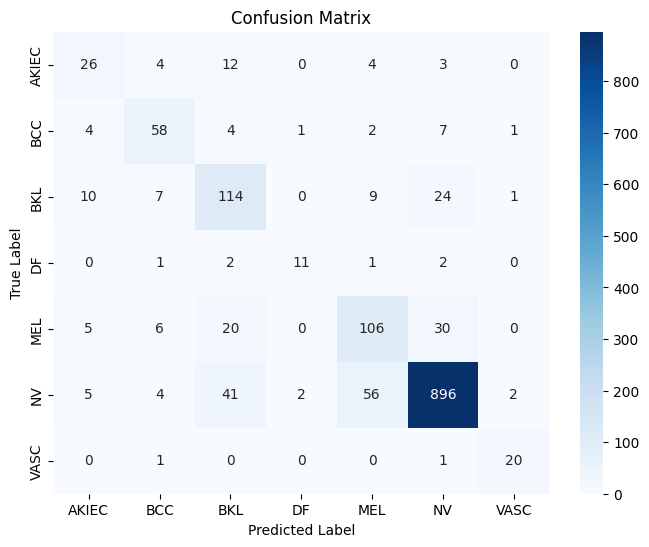


Per-Class Metrics:
AKIEC: Precision=0.5200, Recall=0.5306, F1-score=0.5253
BCC: Precision=0.7160, Recall=0.7532, F1-score=0.7342
BKL: Precision=0.5907, Recall=0.6909, F1-score=0.6369
DF: Precision=0.7857, Recall=0.6471, F1-score=0.7097
MEL: Precision=0.5955, Recall=0.6347, F1-score=0.6145
NV: Precision=0.9304, Recall=0.8907, F1-score=0.9101
VASC: Precision=0.8333, Recall=0.9091, F1-score=0.8696


In [9]:


def evaluate_model(model, test_loader, class_names):
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

    # Compute per-class precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Display per-class precision, recall, and F1-score
    print("\nPer-Class Metrics:")
    for i, cls in enumerate(class_names):
        print(f"{cls}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-score={f1[i]:.4f}")

# Get class names from dataset
class_names = list(train_dataset.class_to_idx.keys())

# Run evaluation
evaluate_model(model, test_loader, class_names)


Epoch 1/20: Train Loss: 0.7047, Val Loss: 0.6606, IoU: 0.0006, Dice: 0.0012
Segmentation model saved!
Epoch 2/20: Train Loss: 0.6462, Val Loss: 0.6316, IoU: 0.6977, Dice: 0.8217
Segmentation model saved!
Epoch 3/20: Train Loss: 0.6318, Val Loss: 0.6292, IoU: 0.7057, Dice: 0.8272
Segmentation model saved!
Epoch 4/20: Train Loss: 0.6301, Val Loss: 0.6284, IoU: 0.6998, Dice: 0.8231
Epoch 5/20: Train Loss: 0.6290, Val Loss: 0.6305, IoU: 0.6526, Dice: 0.7895
Epoch 6/20: Train Loss: 0.6283, Val Loss: 0.6277, IoU: 0.7053, Dice: 0.8269
Epoch 7/20: Train Loss: 0.6274, Val Loss: 0.6266, IoU: 0.7209, Dice: 0.8376
Segmentation model saved!
Epoch 8/20: Train Loss: 0.6268, Val Loss: 0.6269, IoU: 0.7021, Dice: 0.8247
Epoch 9/20: Train Loss: 0.6263, Val Loss: 0.6264, IoU: 0.7124, Dice: 0.8318
Epoch 10/20: Train Loss: 0.6265, Val Loss: 0.6266, IoU: 0.7344, Dice: 0.8466
Segmentation model saved!
Epoch 11/20: Train Loss: 0.6259, Val Loss: 0.6260, IoU: 0.7111, Dice: 0.8309
Epoch 12/20: Train Loss: 0.6255,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


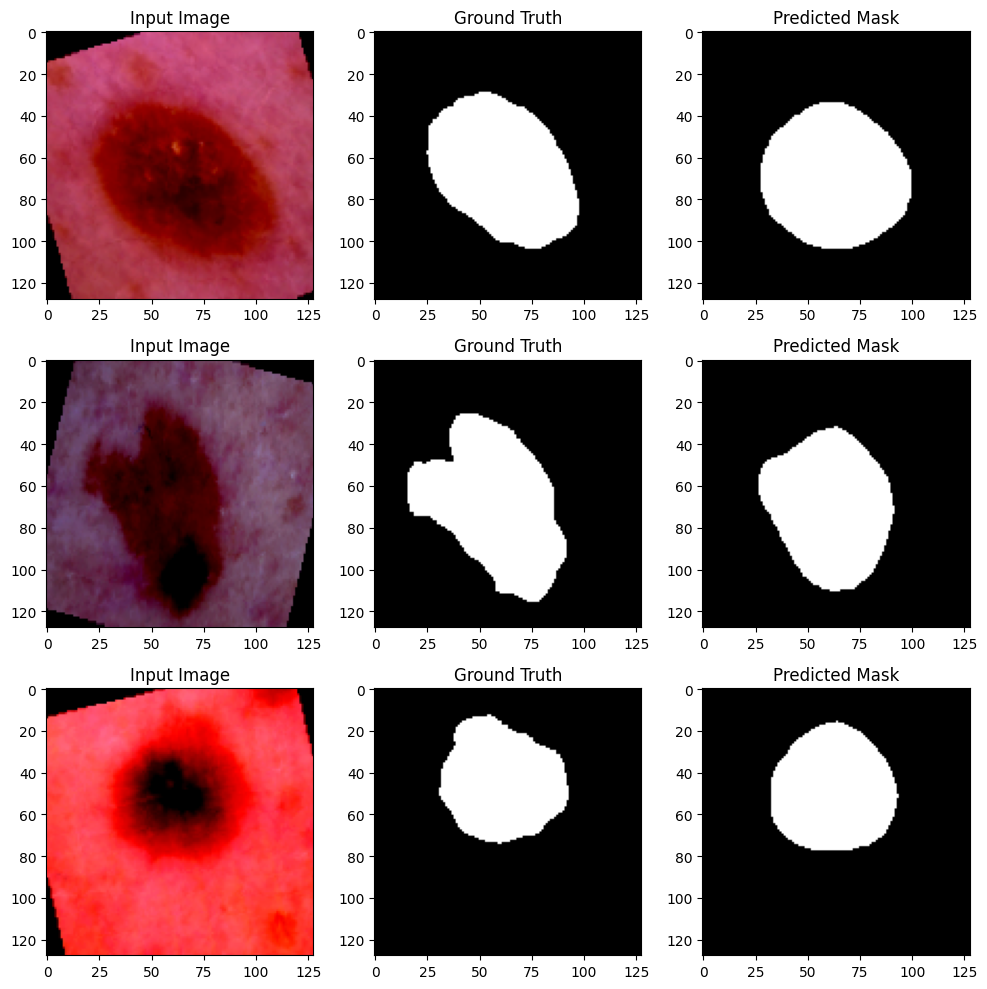

In [ ]:
# Segmentation Model Implementation and Evaluation

# First, let's modify the dataset to handle segmentation masks
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mask_transform = mask_transform or transforms.Compose([transforms.Resize((128, 128), Image.NEAREST), transforms.ToTensor()])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        mask_path = row['mask_path']
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

# U-Net like architecture with Batch Normalization and Dropout
class UNetLike(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder (using ResNet18 as backbone)
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        
        # Encoder layers
        self.encoder1 = nn.Sequential(*self.base_layers[:3])  # size: (N, 64, 64, 64)
        self.encoder2 = nn.Sequential(*self.base_layers[3:5])  # size: (N, 64, 32, 32)
        self.encoder3 = self.base_layers[5]                   # size: (N, 128, 16, 16)
        self.encoder4 = self.base_layers[6]                   # size: (N, 256, 8, 8)
        
        # Bridge
        self.bridge = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Decoder layers
        self.decoder4 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        # Channel reduction layers
        self.reduce4 = nn.Conv2d(384, 256, kernel_size=1)
        self.reduce3 = nn.Conv2d(192, 128, kernel_size=1)
        self.reduce2 = nn.Conv2d(128, 64, kernel_size=1)
        
        # Final layer
        self.final = nn.Conv2d(32, 1, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)      # 64, 64, 64
        e2 = self.encoder2(e1)     # 64, 32, 32
        e3 = self.encoder3(e2)     # 128, 16, 16
        e4 = self.encoder4(e3)     # 256, 8, 8
        
        # Bridge
        b = F.relu(self.bridge(e4)) # 512, 8, 8
        
        # Decoder with skip connections
        d4 = F.relu(self.decoder4(b)) # 256, 16, 16
        d4 = torch.cat([d4, e3], dim=1) # 256+128=384
        d4 = F.relu(self.reduce4(d4))  # 256, 16, 16
        
        d3 = F.relu(self.decoder3(d4)) # 128, 32, 32
        d3 = torch.cat([d3, e2], dim=1) # 128+64=192
        d3 = F.relu(self.reduce3(d3))  # 128, 32, 32
        
        d2 = F.relu(self.decoder2(d3)) # 64, 64, 64
        d2 = torch.cat([d2, e1], dim=1) # 64+64=128
        d2 = F.relu(self.reduce2(d2))  # 64, 64, 64
        
        d1 = F.relu(self.decoder1(d2)) # 32, 128, 128
        
        # Final layer with sigmoid activation
        return torch.sigmoid(self.final(d1))

# Model Initialization
seg_model = UNetLike().to(device)

# Optimizer and Loss Function
optimizer = optim.AdamW(seg_model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # Using BCE loss for binary segmentation

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1, verbose=True)

def iou_score(pred, target):
    # Convert the predictions and targets to binary (0 or 1)
    pred = pred.int()
    target = target.int()
    
    # Compute the intersection and union
    intersection = (pred & target).float().sum()
    union = (pred | target).float().sum()
    
    return (intersection + 1e-6) / (union + 1e-6)

# Similarly, ensure your dice_coeff function also works with binary masks
def dice_coeff(pred, target):
    pred = pred.int()
    target = target.int()
    
    intersection = (pred & target).float().sum()
    return (2.0 * intersection + 1e-6) / (pred.float().sum() + target.float().sum() + 1e-6)

# Training Loop with improved logging and scheduler
def train_segmentation_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_iou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        iou = 0.0
        dice = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                preds = (outputs > 0.5).float()
                iou += iou_score(preds, masks)
                dice += dice_coeff(preds, masks)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_iou = iou / len(val_loader)
        avg_dice = dice / len(val_loader)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}")
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), "best_seg_model.pth")
            print("Segmentation model saved!")

# Train the model with scheduler
train_segmentation_model(seg_model, seg_train_loader, seg_val_loader, criterion, optimizer, scheduler, epochs=20)

# Evaluation function for segmentation
def evaluate_segmentation_model(model, test_loader):
    model.load_state_dict(torch.load("best_seg_model.pth"))
    model.eval()
    
    test_iou = 0.0
    test_dice = 0.0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            test_iou += iou_score(preds, masks)
            test_dice += dice_coeff(preds, masks)
    
    avg_iou = test_iou / len(test_loader)
    avg_dice = test_dice / len(test_loader)
    
    print(f"\nTest Results - IoU: {avg_iou:.4f}, Dice Coefficient: {avg_dice:.4f}")
    
    # Visualize some predictions
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(3):
        img, mask = seg_test_dataset[i]
        img = img.unsqueeze(0).to(device)
        pred = model(img)
        pred_mask = (pred > 0.5).float().squeeze().cpu().numpy()
        
        axes[i,0].imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
        axes[i,0].set_title("Input Image")
        axes[i,1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
        axes[i,1].set_title("Ground Truth")
        axes[i,2].imshow(pred_mask, cmap='gray')
        axes[i,2].set_title("Predicted Mask")
    
    plt.tight_layout()
    plt.show()

# Evaluate the model
evaluate_segmentation_model(seg_model, seg_test_loader)